In [ ]:
import pandas as pd

PriorKnowledgeJossen=pd.read_json('PriorKnowledge.json')

StorageTemperatures=[data['Storage_Temperature'] for data in PriorKnowledgeJossen['data']]
UsedStoredSpecificEnergy=[data['Used_Stored_Specific_Energy'] for data in PriorKnowledgeJossen['data']]
# years to 80% in DOE
# days to loose 1Wh/kg in Enpolite to years to loose 20%
# LifetimeCoefficient/(max(UsedStoredSpecificEnergy)*100/365)
Lifetime=[data['Lifetime_Coefficient']/(max(UsedStoredSpecificEnergy)*100/365) for data in PriorKnowledgeJossen['data']]

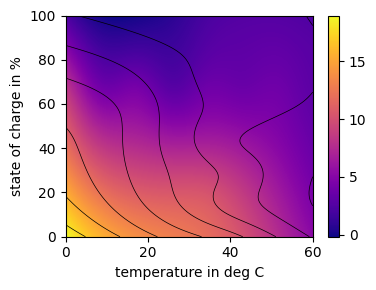

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
from scipy.interpolate import griddata

# Sample data

# Function to normalize to a specific range
# def normalize(data, new_min, new_max):
#     data_min = np.min(data)
#     data_max = np.max(data)
#     return (new_max - new_min) * (data - data_min) / (data_max - data_min) + new_min

# Normalize x and y to the range [-1, 1]
# x_normalized = normalize(StorageTemperatures, -1, 1)
# y_normalized = normalize(UsedStoredSpecificEnergy, -1, 1)

# Normalize z to the range [0, 1]
# z_normalized = Lifetime

# Create grid values for interpolation
grid_x, grid_y = np.mgrid[0:60:200j, 0:100:200j]

# Interpolate the data
grid_z = griddata((StorageTemperatures, UsedStoredSpecificEnergy), Lifetime, (grid_x, grid_y), method='cubic')

# Interpolate the data using Rbf
rbf = Rbf(StorageTemperatures, UsedStoredSpecificEnergy, Lifetime, function='cubic')
grid_z = rbf(grid_x, grid_y)

# Create the plot
plt.figure(figsize=(4, 3))  # Smaller figure size for a minimalistic look
plt.imshow(grid_z, extent=(0, 60, 0, 100), origin='lower', cmap='plasma', aspect='auto')
plt.colorbar()
plt.xlabel('temperature in deg C')
plt.ylabel('state of charge in %')
plt.tight_layout()  # Use tight layout for minimalistic look
plt.grid(False)  # Remove grid for minimalistic look

# Add contour lines
contours = plt.contour(grid_x, grid_y, grid_z, levels=8, colors='black', linewidths=0.5)
#plt.clabel(contours, inline=True, fontsize=8)

plt.show()

In [13]:
import torch
from scipy.interpolate import Rbf

# Assume x_normalized, y_normalized, z_normalized are your data points
# And rbf is your interpolated function
rbf = Rbf(x_normalized, y_normalized, z_normalized, function='cubic')

# Set the seed and number of initial samples
seed = 2024
n_initial = 15
torch.manual_seed(seed)

# Generate a large number of random samples in the normalized range [-1, 1]
N = 10000
x_samples = torch.empty(N).uniform_(-1, 1)
y_samples = torch.empty(N).uniform_(-1, 1)

# Compute the cost z(x, y) for each sample using the RBF interpolator
z_samples = torch.from_numpy(rbf(x_samples.numpy(), y_samples.numpy()))

# Compute the weights inversely proportional to the cost
w_samples = 1.0 / z_samples
w_samples = torch.clamp(w_samples, min=1e-6)  # Avoid division by zero

# Normalize the weights to get probabilities
p_samples = w_samples / w_samples.sum()

# Sample indices based on the computed probabilities
indices = torch.multinomial(p_samples, n_initial, replacement=False)

# Select the samples corresponding to the chosen indices
x_selected = x_samples[indices]
y_selected = y_samples[indices]

# Now x_selected and y_selected are your samples that favor less costly tests


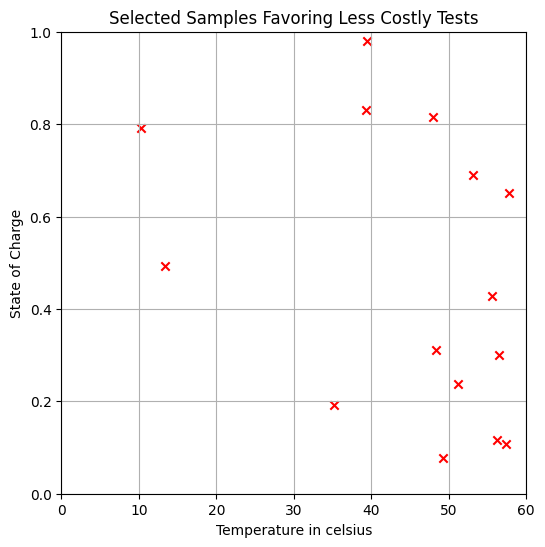

In [14]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(6, 6))
plt.scatter(x_selected.numpy()*30+30, y_selected.numpy()*0.5+0.5, color='red', marker='x')

# Set the limits of the plot from -1 to 1 on both axes
#plt.xlim(-1, 1) #x_norm*30+30
plt.xlim(0, 60) #x_norm*30+30
#plt.ylim(-1, 1) #y_norm*0.5+0.5
plt.ylim(0, 1) #y_norm*0.5+0.5

# Set equal aspect ratio
#plt.gca().set_aspect('equal', adjustable='box')

# Add labels and title
#plt.xlabel('Temperature (normalized)')
plt.xlabel('Temperature in celsius')
#plt.ylabel('State of Charge (normalized)')
plt.ylabel('State of Charge')
plt.title('Selected Samples Favoring Less Costly Tests')

# Show grid
plt.grid(True)

# Display the plot
plt.show()


In [15]:
np.round((y_selected.numpy()*0.5+0.5)*100)  

array([12., 82., 49., 65., 43., 79., 24., 83.,  8., 19., 31., 69., 30.,
       98., 11.], dtype=float32)

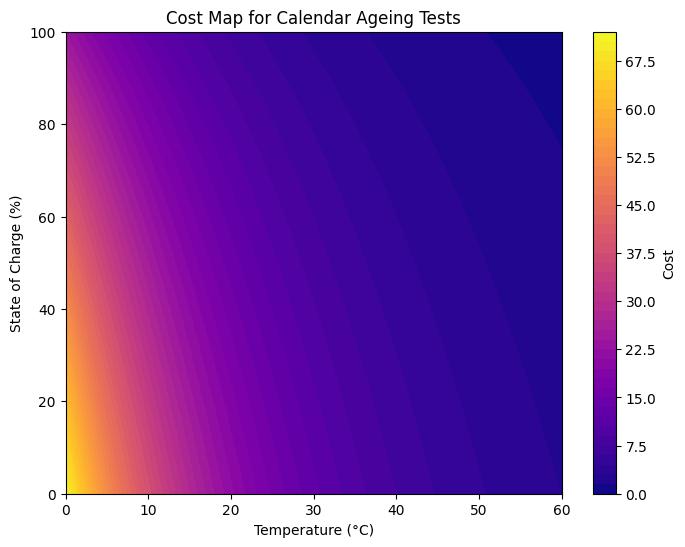

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
Ea = 40000  # J/mol
R = 8.314   # J/(mol·K)
T_ref = 333 # K
k_SOC = 2

# Temperature and SOC ranges
temperatures = np.linspace(0 + 273.15, 60 + 273.15, 50)  # 0°C to 60°C
socs = np.linspace(0, 100, 50)

# Create meshgrid
T_grid, SOC_grid = np.meshgrid(temperatures, socs)

# Compute temperature-dependent cost
Cost_temp = np.exp((Ea / R) * (1 / T_grid - 1 / T_ref))

# Compute SOC-dependent cost
Cost_SOC = 1 + k_SOC * (100 - SOC_grid) / 100

# Compute total cost
Total_Cost = Cost_temp * Cost_SOC

# Plotting the cost map
plt.figure(figsize=(8, 6))
cp = plt.contourf(T_grid - 273.15, SOC_grid, Total_Cost, levels=50, cmap='plasma')
plt.colorbar(cp, label='Cost')
plt.xlabel('Temperature (°C)')
plt.ylabel('State of Charge (%)')
plt.title('Cost Map for Calendar Ageing Tests')
plt.show()